- Inputs (either/or):
    - Binary vectors (Bernoulli)
    - bipolar vectors (Rademacher)
    - real values vectors (Gaussian)
- Objectives (either/or):
    - classify perfect match vs every other vector under varying SNR
    - maximize information gain
- Thresholds (either/or):
    - uniformly spaced
    - symmetric but non-uniformly spaced
    - arbitrarily spaced

In [1]:
%pip install -q jax jaxlib numpyro numpy matplotlib funsor seaborn xarray
import __init__
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp


import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from adim import *


Note: you may need to restart the kernel to use updated packages.
Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vector_length = 256
num_bits = np.arange(1,jnp.log2(vector_length).astype(int)+1)
phase = np.linspace(-0.75, 0.75, 100)
scale = np.linspace(0.01, 5, 100)

noise_std = jnp.array([0.1, 0.25, 0.5, 1.0])
fixed = np.arange(0, 3)

MIs = sweep(
    vector_length,
    num_bits,
    phase,
    scale,
    noise_std,
    distribution="bipolar",
    fixed=jnp.array([0]),
)
MIs

<xarray.DataArray (num_bits: 8, fixed: 1, noise_std: 4, phase: 100, scale: 100)> Size: 3MB
Array([[[[[0.95066757, 0.96513115, 0.98464387, ..., 0.91585995,
           0.91585994, 0.91585964],
          [0.9506482 , 0.96463242, 0.98393364, ..., 0.91585995,
           0.91585995, 0.91585995],
          [0.95062922, 0.96413671, 0.98320236, ..., 0.91585995,
           0.91585995, 0.91585995],
          ...,
          [0.95062922, 0.96413671, 0.98320236, ..., 0.91585995,
           0.91585995, 0.91585995],
          [0.9506482 , 0.96463242, 0.98393364, ..., 0.91585995,
           0.91585995, 0.91585995],
          [0.95066757, 0.96513115, 0.98464387, ..., 0.91585995,
           0.91585994, 0.91585964]],

         [[0.95025909, 0.95295466, 0.95890526, ..., 0.91379371,
           0.91163958, 0.90795144],
          [0.95025596, 0.95284679, 0.95858827, ..., 0.91546574,
           0.9149203 , 0.91379998],
          [0.9502529 , 0.95274089, 0.95827531, ..., 0.91579692,
           0.91570949, 0.91548168],
...
          [1.57284251, 3.71297567, 4.62730595, ..., 2.66805823,
           2.67308995, 2.67337666],
          [1.57284084, 3.71299247, 4.6273111 , ..., 2.65773605,
           2.65521521, 2.65022129],
          [1.57283913, 3.71300961, 4.62731633, ..., 2.64441344,
           2.63188544, 2.61965836]],

         [[1.39461712, 3.12521398, 3.8223524 , ..., 2.5135057 ,
           2.50189754, 2.49038868],
          [1.39461719, 3.12521475, 3.82235368, ..., 2.51388493,
           2.50260539, 2.49137841],
          [1.39461726, 3.1252155 , 3.82235494, ..., 2.51417985,
           2.50315588, 2.49214811],
          ...,
          [1.39461726, 3.1252155 , 3.82235494, ..., 2.51417985,
           2.50315588, 2.49214811],
          [1.39461719, 3.12521475, 3.82235368, ..., 2.51388493,
           2.50260539, 2.49137841],
          [1.39461712, 3.12521398, 3.8223524 , ..., 2.5135057 ,
           2.50189754, 2.49038868]]]]], dtype=float64)
Coordinates:
  * num_bits   (num_bits) int64 64B 1 2 3 4 5 6 7 8
  * fixed      (fixed) int64 8B 0
  * noise_std  (noise_std) float64 32B 0.1 0.25 0.5 1.0
  * phase      (phase) float64 800B -0.75 -0.7348 -0.7197 ... 0.7197 0.7348 0.75
  * scale      (scale) float64 800B 0.01 0.0604 0.1108 0.1612 ... 4.899 4.95 5.0

/var/folders/2t/lcrnl5t504q810ckz7k6ggtm0000gn/T/ipykernel_4537/3511726329.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  fg.axes[i,k].set_title(f"{int(n)} bits, noise_std={float(s):.2f}")
/var/folders/2t/lcrnl5t504q810ckz7k6ggtm0000gn/T/ipykernel_4537/3511726329.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  fg.axes[i,k].plot(max_phase[i,j,k], max_scale[i,j,k], "kx")


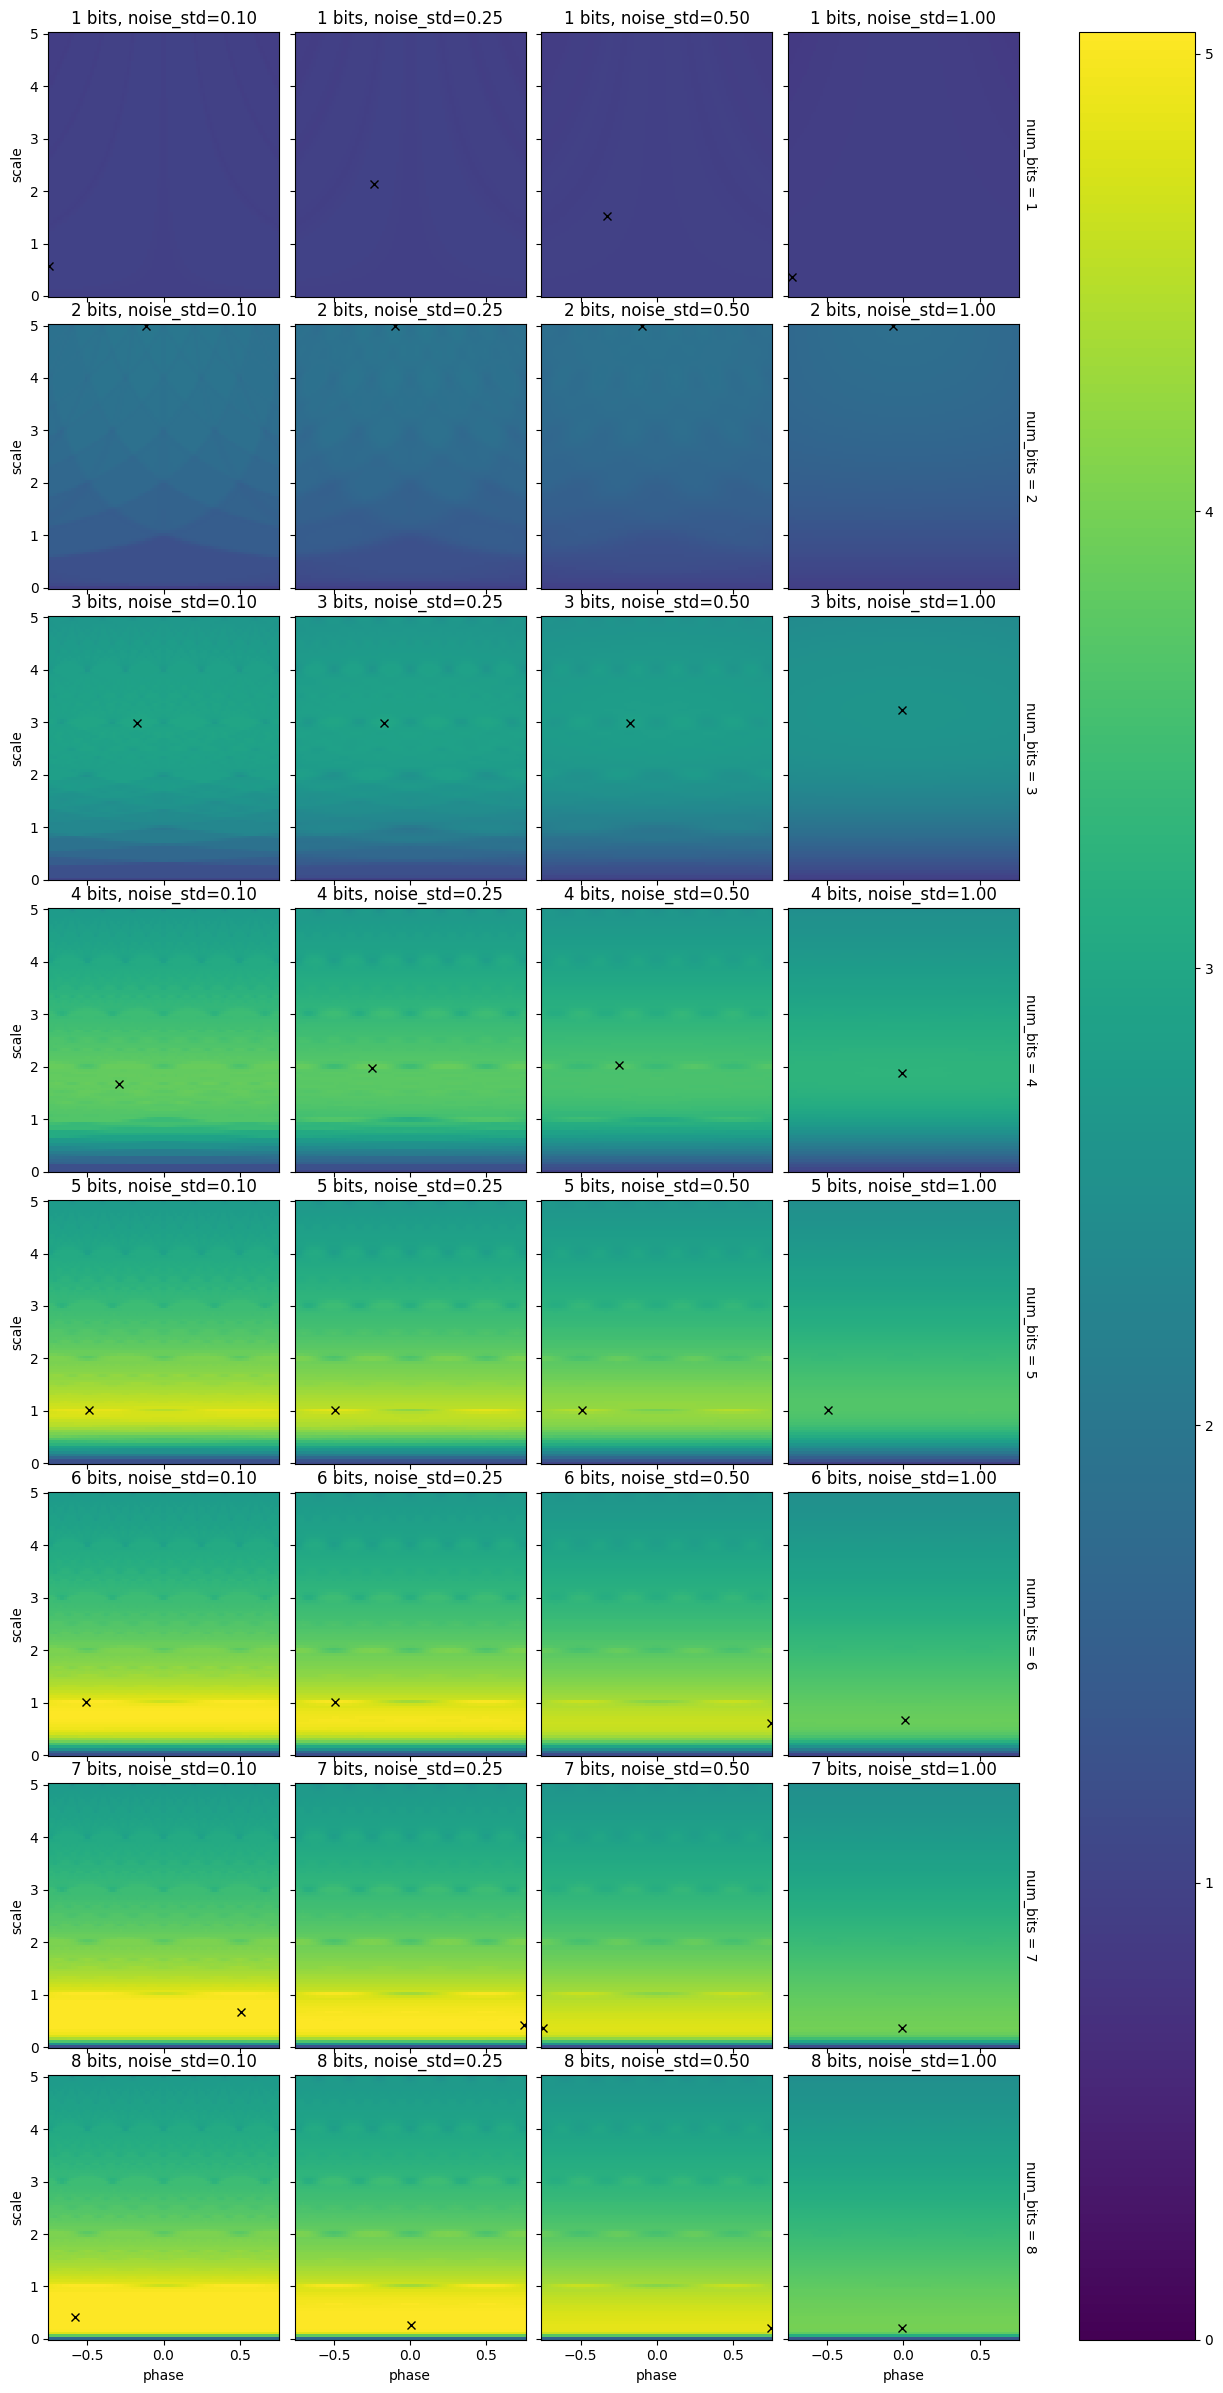

In [3]:
fg = MIs.isel(fixed=0).squeeze().plot(row="num_bits", col="noise_std", x="phase", y="scale", cmap="viridis", vmin=0)
max_idx = MIs.argmax(dim=("phase", "scale"))

max_phase = MIs.coords["phase"][max_idx["phase"]]
max_scale = MIs.coords["scale"][max_idx["scale"]]
max_MI = MIs.max(dim=("phase", "scale"))

for i,n in enumerate(MIs.coords["num_bits"]):
    for j,f in enumerate(MIs.coords["fixed"]):
        for k,s in enumerate(MIs.coords["noise_std"]):
            fg.axes[i,k].set_title(f"{int(n)} bits, noise_std={float(s):.2f}")
            fg.axes[i,k].plot(max_phase[i,j,k], max_scale[i,j,k], "kx")

In [8]:


from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnectorPatch

def plot_panel(num_bits_idx, fixed_idx, noise_std_idx, distribution="bipolar", inset=None, ax=None, fig_kwargs=dict(figsize=(6,6)), threshold_kwargs=dict(linestyle=":", linewidth=1, color="black"), inside_color="C0", outside_color="C1", inset_color=None, connector_kwargs=dict(loc1a=3, loc1b=4, loc2a=2, loc2b=1)):
    if ax is None:
        fig, (ax_fun, ax_density, ax_zoomed) = plt.subplots(3,1, **fig_kwargs)
    else:
        fig = ax[0].get_figure()
        ax_fun, ax_density, ax_zoomed = ax
    
    # extract the precise parameters to plot
    phase = float(max_phase[dict(num_bits=num_bits_idx, fixed=fixed_idx, noise_std=noise_std_idx)])
    scale = float(max_scale[dict(num_bits=num_bits_idx, fixed=fixed_idx, noise_std=noise_std_idx)])
    num_bits = int(MIs.coords["num_bits"][num_bits_idx])
    fixed = int(MIs.coords["fixed"][fixed_idx])
    noise_std = float(MIs.coords["noise_std"][noise_std_idx])

    # compute the optimal thresholds for the given parameters
    opt_thresholds = compute_thresholds(num_bits, phase, scale, distribution=distribution, vector_length=vector_length).ravel()
    tmin, tmax = float(opt_thresholds[1]), float(opt_thresholds[-2])

    if inset:
        xmin, xmax = inset
    else:
        xmin, xmax = tmin-10, tmax+10


    # compute the "background" probability distribution
    nn = np.arange(vector_length+1)
    if distribution == "bipolar":
        nn = nn * 2 - vector_length
    # pp = np.exp(dists.Binomial(vector_length, 0.5).log_prob(xx))
    p_n = jnp.exp(log_pdf_n(nn, vector_length=vector_length, distribution=distribution, fixed=fixed))

    ymin, ymax = -p_n.max()*0.05, p_n.max()*1.05

    # create the function plot
    xx = np.linspace(nn[0], nn[-1], 1001)
    ax_fun_twin = ax_fun.twinx()
    l1 = ax_fun.plot(nn, jnp.cumsum(p_n), color="gray", label="CDF")
    ax_fun_twin.add_patch(Rectangle((xmin, -0.05*((1<<num_bits)-1)), xmax-xmin, 1.1*((1<<num_bits)-1), edgecolor="black", facecolor=inset_color))
    l2 = ax_fun_twin.plot(xx, jnp.searchsorted(opt_thresholds, xx)-1, color="black", linewidth=1, label="quantization")
    ax_fun.yaxis.tick_right()
    ax_fun_twin.yaxis.tick_left()
    ax_fun.yaxis.label.set_color("gray")
    ax_fun.tick_params(axis="y", colors="gray")
    ax_fun_twin.yaxis.label.set_color("black")
    ax_fun.yaxis.set_label_position("right")
    ax_fun_twin.yaxis.set_label_position("left")
    ax_fun.set_ylabel("CDF")
    ax_fun_twin.set_ylabel("Level")
    ax_fun.set_title(f"{num_bits}-bit quantization")
    ax_fun.set_ylim(-0.1, 1.1)
    # ax_fun_twin.set_ylim()
    lines = l1+l2
    labels = [l.get_label() for l in lines]
    ax_fun.legend(handles=lines, labels=labels, loc="upper left")
    ax_fun.sharex(ax_density)
    ax_fun.xaxis.set_major_locator(MultipleLocator(64))
    ax_fun_twin.yaxis.set_major_locator(MaxNLocator(integer=True))

    # create the density plot
    
    # compute area between thresholds
    total = p_n.sum(where=(tmin <= nn) * (nn <= tmax))
    rect=Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="black", facecolor=inset_color)
    ax_density.add_patch(rect)
    # ax.fill_between(nn, ymax, p_n, where=(nn >= xmin) * (nn <= xmax), color=threshold_color)
    ax_density.fill_between(nn, p_n, 0, where=(nn >= tmin) * (nn <= tmax), color=inside_color, alpha=0.5, label=f"in range ({100*total:.1f}%)")
    ax_density.fill_between(nn, p_n, 0, where=np.logical_not((nn >= tmin) * (nn <= tmax)), color=outside_color, alpha=0.5, label=f"clipped ({100*(1-total):.1f}%)")
    # ax.vlines([opt_thresholds[1],opt_thresholds[-2]], 0, ymax, color=threshold_color)
    ax_density.plot(nn, p_n, color="gray")

    # create the zoomed-in plot
    xx = np.linspace(xmin, xmax, 1001)

    p_x = jnp.exp(log_pdf_x(xx, noise_std=noise_std, vector_length=vector_length, distribution=distribution, fixed=fixed))
    p_n = jnp.exp(log_pdf_n(nn, vector_length=vector_length, distribution=distribution, fixed=fixed))

    c = BboxConnectorPatch(TransformedBbox(rect.get_bbox(), ax_density.transData), ax_zoomed.bbox, **connector_kwargs, clip_on=False)

    ax_zoomed.add_patch(c)

    idx_in = (tmin <= xx) * (xx <= tmax)
    ax_zoomed.patch.set_color(inset_color)
    ax_zoomed.fill_between(xx, p_x, 0, where=idx_in, color=inside_color, alpha=0.5)
    ax_zoomed.fill_between(xx, p_x, 0, where=np.logical_not(idx_in), color=outside_color, alpha=0.5) 
    ax_zoomed.plot(xx, p_x, color="gray")
    ax_density.legend(loc = "upper left")
    ax_zoomed_twin=ax_zoomed.twinx()
    ax_zoomed_twin.plot(nn, p_n, "-", color="gray")

    ymin, ymax = -p_x.max()*0.05, p_x.max()*1.05
    ax_zoomed.set_ylim(ymin, ymax)
    ax_zoomed.set_xlim(xmin, xmax)

    ax_density.set_yticks([])
    ax_zoomed.set_yticks([])
    ax_zoomed_twin.set_yticks([])

    ax_zoomed.vlines(opt_thresholds, ymin, ymax, **threshold_kwargs)
    ax_density.set_title(f"Distribution of dot-products")
    fig.tight_layout(h_pad=-0.5)
    return fig, ax_density

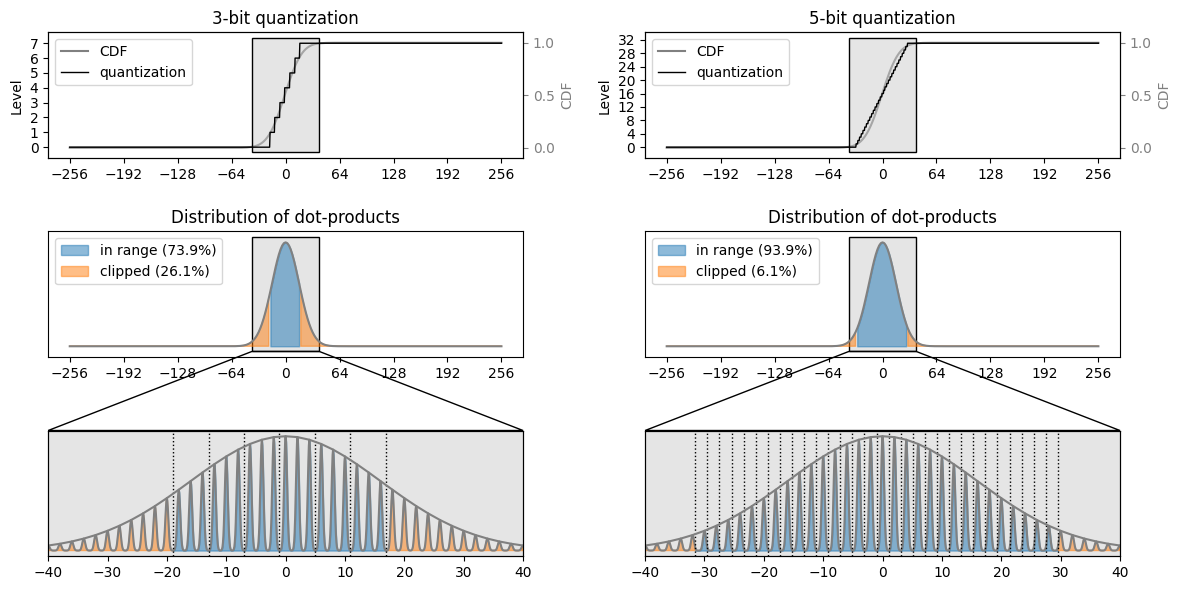

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(12,6))

plot_panel(2, 0, 1, ax=ax[:,0], inset=(-40, 40), inset_color=(0.8,0.8,0.8, 0.5))
plot_panel(4, 0, 1, ax=ax[:,1], inset=(-40, 40), inset_color=(0.8,0.8,0.8, 0.5))


fig.savefig("../figures/quantization.pdf")
fig.savefig("../figures/quantization.svg")
fig.savefig("../figures/quantization.png", dpi=300)
